Enfoque del dataset de noticias falsas basado en RNN

In [1]:
### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
tf.random.set_seed(55) # para asegurar experimentos son reproducibles
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import gensim.downloader as api

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Cargar Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/My Drive/TFM/Data/HuHu/"

Mounted at /content/drive


In [3]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df = pd.read_csv(PATH + "train.csv",  sep=',', on_bad_lines='skip', encoding='utf-8', encoding_errors='ignore', index_col=False)
df = df[['tweet', 'prejudice_woman', 'prejudice_lgbtiq', 'prejudice_inmigrant_race', 'gordofobia']]
df = df.rename(columns={"tweet": "Text", "prejudice_woman": "Label1", "prejudice_lgbtiq": "Label2", "prejudice_inmigrant_race": "Label3", "gordofobia": "Label4"})
df.fillna(" ", inplace=True)

X_train = df['Text']
y_train = pd.DataFrame({'Label1':df['Label1'], 'Label2':df['Label2'], 'Label3':df['Label3'], 'Label4':df['Label4']})

X_train, X_aux, y_train, y_aux = train_test_split(X_train, y_train, test_size=0.3, random_state=55)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.66, random_state=55)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 1869
Tamaño conjunto de Validación: 272
Tamaño conjunto de Evaluación: 530


# Preprocesamiento y Limpieza

In [4]:
### LIMPIEZA DE TEXTOS ###
stopwords_es = stopwords.words("spanish")
def clean_text(text):
    # transformar a minúscula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_es]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con menos de 2 caráceres
    # ignoramos cualquier palabra que contenga un digito o un símbolo especial
    min_length = 2
    p = re.compile('^[a-zA-Z]+$');
    filtered_tokens=""
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens = filtered_tokens + str(token) + " "

    if filtered_tokens == "":
        return "nada"
    else:
        return filtered_tokens

for index in X_train.index:
    X_train[index] = clean_text(X_train[index])

# Label Encoding

No es necesario hacer Label Encoding

# Tokenización

In [5]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_val = tokenizer.texts_to_sequences(X_val)
encoded_test = tokenizer.texts_to_sequences(X_test)

Tamaño del vocabulario = 5840


In [6]:
MAX_LEN = 55

encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

# Matriz de Embedding

In [7]:
#model_we = api.load("glove-wiki-gigaword-50")       #EMBED_SIZE = 50
#model_we = api.load("glove-twitter-200")          #EMBED_SIZE = 200
#model_we = api.load("word2vec-google-news-300")     #EMBED_SIZE = 300

model_we = api.load("glove-twitter-200")
EMBED_SIZE = 200

# creamos una matriz para los textos del conjunto de entrenamiento
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model_we[word]
        # word embedding para la palabra con índice i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

[==================================================] 100.0% 758.5/758.5MB downloaded


# BiLSTM

In [8]:
EMBEDDING_SIZE = EMBED_SIZE
DROPOUT = 0.4

model = Sequential()
# capa donde se crea la matriz de word embeddings
# Cada token está asociado con un entero (gracias a la tokenización)
# Cada entero está asociado a un vector de la matriz
# Las secuencias se representan con estos vectores
model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN, weights=[embedding_matrix]))

model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.2)))
# Añadimos una capaz droput después de la capa bilstm
model.add(Dropout(DROPOUT))

model.add(Bidirectional(LSTM(50, recurrent_dropout=0.2)))
model.add(Dropout(DROPOUT))

model.add(Dense(50, activation='relu'))

model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 200)           1168000   
                                                                 
 bidirectional (Bidirectiona  (None, 55, 200)          240800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 55, 200)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              100400    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5

Training:

In [9]:
# Entrenamos el modelo
epochs = 20 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
batch_size = 16

# training
history=model.fit(encoded_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val), callbacks=[earlyStopping])


Epoch 1/20
117/117 [==============================] - 131s 983ms/step - loss: 0.4260 - accuracy: 0.6233 - val_loss: 0.4345 - val_accuracy: 0.5772
Epoch 2/20
117/117 [==============================] - 106s 899ms/step - loss: 0.2502 - accuracy: 0.8143 - val_loss: 0.3947 - val_accuracy: 0.6471
Epoch 3/20
117/117 [==============================] - 102s 874ms/step - loss: 0.1579 - accuracy: 0.8743 - val_loss: 0.3949 - val_accuracy: 0.6103
Epoch 4/20
117/117 [==============================] - 106s 905ms/step - loss: 0.1202 - accuracy: 0.9090 - val_loss: 0.4741 - val_accuracy: 0.5699
Epoch 5/20
117/117 [==============================] - 103s 877ms/step - loss: 0.0921 - accuracy: 0.9272 - val_loss: 0.4461 - val_accuracy: 0.5846


Curvas de Aprendizaje:

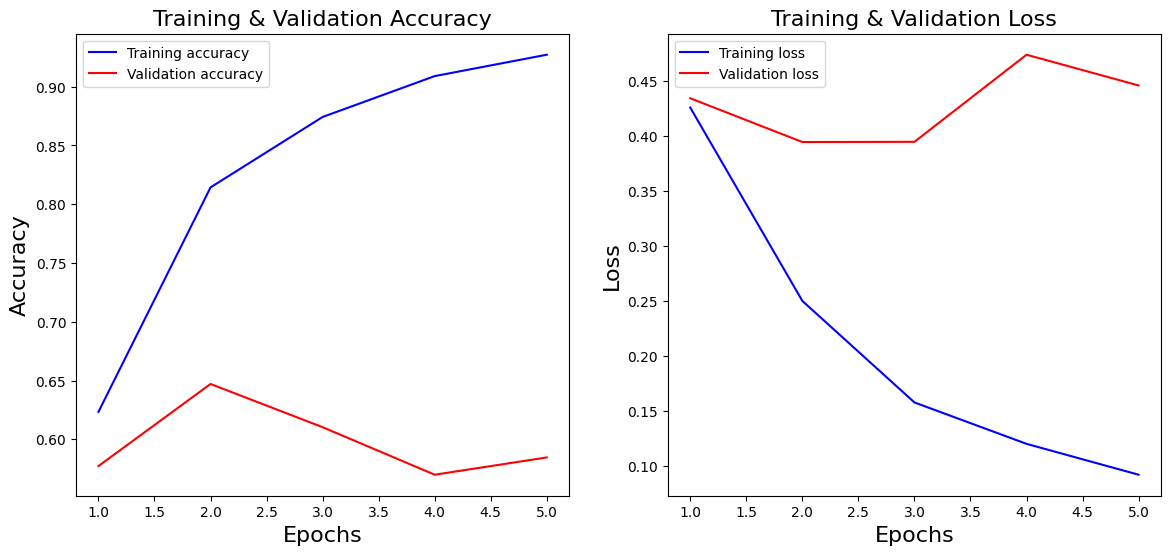

In [10]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()

# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Evaluación:

In [11]:
loss, accuracy = model.evaluate(encoded_test, y_test, batch_size=batch_size)

y_pred = np.argmax(model.predict(encoded_test), axis=1)
y_test_2 = np.asmatrix(y_test)
rounded_y_test = np.argmax(y_test_2, axis=1)

print(classification_report(np.asarray(rounded_y_test), y_pred))

17/17 [==============================] - 2s 67ms/step
              precision    recall  f1-score   support

           0       0.70      0.65      0.68       251
           1       0.50      0.61      0.55       132
           2       0.67      0.58      0.62       122
           3       0.58      0.72      0.64        25

    accuracy                           0.63       530
   macro avg       0.61      0.64      0.62       530
weighted avg       0.64      0.63      0.63       530

